In [ ]:
#Importing packages

import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
import random
import cv2

from PIL import Image
import pickle


import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.config.experimental.set_visible_devices(physical_devices[0], 'GPU')

In [ ]:
num_cpus = tf.config.experimental.list_physical_devices('CPU')
print(num_cpus)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


**Displaying an image from validation set**

(64, 64, 3)
tf.Tensor(
[[[0.8901961  0.8901961  0.8901961 ]
  [0.00980392 0.00980392 0.00980392]
  [0.47941178 0.47941178 0.47941178]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 [[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 [[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 ...

 [[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 [[0.         0.         0.        ]
  [0.         

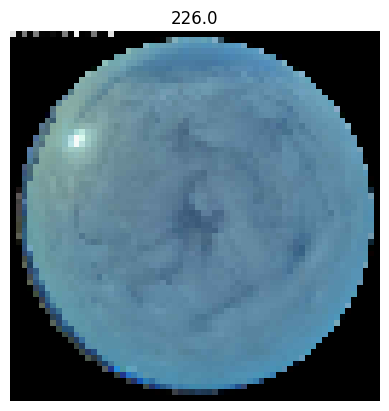

In [4]:
file_path = list(val_ds)[90]
image, label = process_img_label_val(file_path,os.path.join("Val_set_folder","labels"))

def show(image, label):
  plt.figure()
  print(image.shape)
  print(image)
  plt.imshow(image)
  plt.title(label.numpy())
  plt.axis('off')

show(image, label)

**Data Preprocessing and Label Normalization for Sky Camera Image Dataset**

In [ ]:
# Import necessary libraries
from sklearn.preprocessing import MinMaxScaler
import joblib

# Create the MinMaxScaler object for target normalization
target_scaler = MinMaxScaler()

# Define paths to training and validation datasets
train_dataset = tf.data.Dataset.list_files("skycamera_images - Copie/*/*")
val_dataset = tf.data.Dataset.list_files("Val_set_folder/images/*/*")

# Define the total number of samples in the training and validation datasets
len_train = 211000
train_per = 0.5
len_val = 36000
val_per = 0.5

# Calculate the sizes of the training and validation datasets
train_size = int(len_train * train_per)
val_size = int(len_val * val_per)

# Assign datasets to train_ds and val_ds
train_ds = train_dataset
val_ds = val_dataset

# Function to get the label file path for training data
def get_label_train(filepath, labels_folder_path):
    time = tf.strings.split(filepath, sep="\\")[2]
    label_path = tf.strings.join([labels_folder_path, tf.strings.split(filepath, sep="\\")[1], tf.strings.split(time, sep=".")[0] + tf.constant(".txt")], separator="\\")
    return label_path

# Function to get the label file path for validation data
def get_label_val(filepath, labels_folder_path):
    time = tf.strings.split(filepath, sep="\\")[3]
    label_path = tf.strings.join([labels_folder_path, tf.strings.split(filepath, sep="\\")[2], tf.strings.split(time, sep=".")[0] + tf.constant(".txt")], separator="\\")
    return label_path

# Function to process image and label for validation data
def process_img_label_val(filepath, labels_folder_path):
    label_path = get_label_val(filepath, labels_folder_path)
    label = tf.io.read_file(label_path)
    label = tf.strings.to_number(label)
    label = normalize_label(label)
    
    img = tf.io.read_file(filepath)
    img = tf.image.decode_jpeg(img)
    img = img / 255
    img = tf.image.resize(img, [128, 128])  # Scale and resize the image
    
    return img, label

# Function to process image and label for training data
def process_img_label_train(filepath, labels_folder_path):
    label_path = get_label_train(filepath, labels_folder_path)
    label = tf.io.read_file(label_path)
    label = tf.strings.to_number(label)
    label = normalize_label(label)
    
    img = tf.io.read_file(filepath)
    img = tf.image.decode_jpeg(img)
    img = img / 255
    img = tf.image.resize(img, [128, 128])  # Scale and resize the image
    
    return img, label

# Function to normalize the label using Min-Max scaling
def normalize_label(label):
    label = tf.reshape(label, shape=(1, 1))  # Reshape to 2D array
    label = target_scaler.transform(label)  # Normalize the target value
    label = tf.squeeze(label)  # Remove extra dimensions
    return label

# Read and normalize labels for training data
train_labels = [tf.strings.to_number(tf.io.read_file(get_label_train(filepath, "labels_new"))) for filepath in train_dataset]
train_labels = tf.concat(train_labels, axis=0)
train_labels = tf.reshape(train_labels, shape=(-1, 1))  # Reshape to 2D array
train_labels = target_scaler.fit_transform(train_labels)  # Normalize the target values
train_labels = tf.squeeze(train_labels)

# Save the target scaler to a file
joblib.dump(target_scaler, 't_scaler.pkl')

['t_scaler.pkl']

In [ ]:
def augment_image(image, label):
    # Random rotation between -15 to 15 degrees
    image = tf.image.rot90(image, tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))

    return image, label

**Data Pipeline Setup for Training and Validation**

In [4]:
#batch_size= 128
batch_size= 256

train_ds = train_ds.map(lambda x: process_img_label_train(x,"labels_new"), num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.cache('cachee_folder')
train_ds = train_ds.shuffle(buffer_size=1000).batch(batch_size)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

val_ds = val_ds.map(lambda x: process_img_label_val(x,os.path.join("Val_set_folder","labels")), num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(buffer_size=1000).batch(batch_size)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)



**Building a custom sunset model inspired by a research paper**

In [5]:
# define the model architecture using tf.keras API
num_filters = 8
kernel_size = [3,3]
pool_size = [2,2]
strides = 2
dense_size = 1024
drop_rate = 0.5


def sunset_model():
    ## input
    ### input image logs with shape (64,64,24)
    x_in = tf.keras.Input(shape=(128,128,3))

    ## 1st convolution block
    x = tf.keras.layers.Conv2D(num_filters,kernel_size,padding="same",activation='relu')(x_in)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D(pool_size, strides)(x)

    ## 2nd convolution block
    x = tf.keras.layers.Conv2D(num_filters*2,kernel_size,padding="same",activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D([2,2], strides)(x)

    x = tf.keras.layers.Conv2D(num_filters*4,kernel_size,padding="same",activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D([2,2], strides)(x)

    x = tf.keras.layers.Conv2D(num_filters*8,kernel_size,padding="same",activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D([4,4], strides)(x)

    ## two fully connected nets
    x = tf.keras.layers.Flatten()(x)

    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.Dropout(drop_rate)(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(drop_rate)(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dropout(drop_rate)(x)

    ## regression to prediction target
    y_out = tf.keras.layers.Dense(units=1,activation='linear')(x)

    # construct the model
    model = tf.keras.Model(inputs=x_in,outputs=y_out)
    return model

# show model architecture
model=sunset_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 8)       224       
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 8)      32        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 16)        1168      
                                                                 
 batch_normalization_1 (Batc  (None, 64, 64, 16)       64    

**Compiling and training the model**

In [6]:
train_loss = []
val_loss = []
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 60, mode = 'auto'),
    tf.keras.callbacks.ModelCheckpoint(monitor='val_loss',mode='min',save_best_only=True,filepath=os.path.join("models",'model.{epoch:02d}-{val_loss:.2f}.h5'))
]

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='mean_absolute_error', metrics=['mean_absolute_error'], run_eagerly=True)

# Training loop
num_epochs=700

model.fit(train_ds, validation_data=val_ds, epochs=num_epochs,callbacks=my_callbacks,verbose=1)

Epoch 1/700
825/825 [==============================] - 497s 589ms/step - loss: 109.2332 - mean_absolute_error: 109.2332 - val_loss: 77.6463 - val_mean_absolute_error: 77.6463
Epoch 2/700
825/825 [==============================] - 123s 148ms/step - loss: 77.5261 - mean_absolute_error: 77.5261 - val_loss: 52.4126 - val_mean_absolute_error: 52.4126
Epoch 3/700
825/825 [==============================] - 120s 145ms/step - loss: 74.1732 - mean_absolute_error: 74.1732 - val_loss: 34.3718 - val_mean_absolute_error: 34.3718
Epoch 4/700
825/825 [==============================] - 119s 144ms/step - loss: 72.8807 - mean_absolute_error: 72.8807 - val_loss: 35.9811 - val_mean_absolute_error: 35.9811
Epoch 5/700
825/825 [==============================] - 119s 144ms/step - loss: 71.8101 - mean_absolute_error: 71.8101 - val_loss: 44.3569 - val_mean_absolute_error: 44.3569
Epoch 6/700
825/825 [==============================] - 119s 144ms/step - loss: 71.0328 - mean_absolute_error: 71.0328 - val_loss: 35.

**Plotting the train and validation loss**

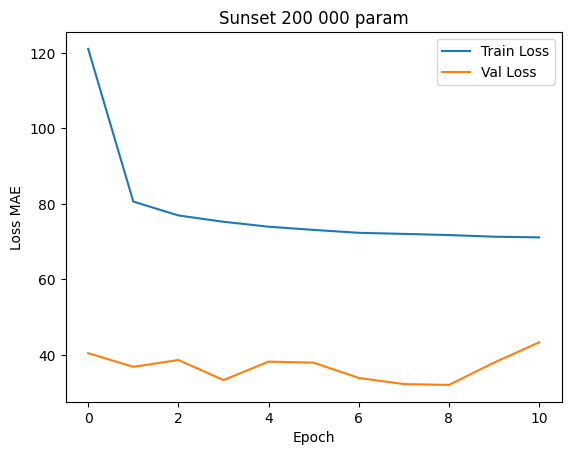

In [26]:
loss=model.history.history['loss']
val_loss=model.history.history['val_loss']

plt.plot(loss, label='Train Loss')
plt.plot(val_loss, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss MAE')
plt.legend()
plt.title('Sunset 200 000 param')
plt.show()

**Fine-Tuning a Pretrained ResNet50 Model with Custom Layers**

In [31]:
#We hope by using pretrained resnet model to have better performances for our regression task, it is a customed
#model (i also modify the last layer and make the activation functiona linear one)
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras import Input


# Define and compile your model architecture
base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False,input_shape=(128,128,3))

# Freeze the first 6 layers
#for layer in base_model.layers[:6]:
#    layer.trainable = False

# Add custom layers on top of the frozen layers
x = GlobalAveragePooling2D()(base_model.layers[-95].output)
#y = Flatten()(x)
z = Dense(256, activation='relu',kernel_regularizer=tf.keras.regularizers.l1(0.01))(x)
z = Dropout(0.4)(z)
w = Dense(128, activation='relu',kernel_regularizer=tf.keras.regularizers.l1(0.01))(z)
w = Dropout(0.4)(w)
final_output = Dense(1, activation='linear')(w)

# Create the modified model

model_resnet=tf.keras.Model(inputs=base_model.input,outputs=final_output)

# Compile the model
#model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mean_squared_error'], run_eagerly=True)

model_resnet.summary()


Model: "model_20"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_21 (InputLayer)          [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_21[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1_conv[0][0]']      

**Compiling and training Resnet Model**

In [32]:
#The training operation was done many times not only one time (the terminal contains the result of the last one)
train_loss = []
val_loss = []
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 140, mode = 'auto'),
    tf.keras.callbacks.ModelCheckpoint(monitor='val_loss',mode='min',save_best_only=True,filepath=os.path.join("models",'model.{epoch:02d}-{val_loss:.2f}.h5'))
]

model_resnet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='mean_squared_error', metrics=['mean_squared_error'], run_eagerly=True)

# Training loop
num_epochs=700

#model=tf.keras.models.load_model("models\\model.03-3695.77.h5")
for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch+1, num_epochs))
    
    # Fit the model and record the loss values
    history = model_resnet.fit(train_ds, validation_data=val_ds, epochs=num_epochs,callbacks=my_callbacks,verbose=1)
    train_loss.append(history.history['loss'])
    val_loss.append(history.history['val_loss'])
    
    # Print the loss for the current epoch
    print('Train Loss: {:.4f}'.format(train_loss[-1]))
    print('Val Loss: {:.4f}'.format(val_loss[-1]))

    np.save('my_history.npy',model.history)
    
    # Plot the loss evolution
    plt.plot(np.arange(epoch+1), train_loss, label='Train Loss')
    plt.plot(np.arange(epoch+1), val_loss, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

#with open('training_history.pkl', 'wb') as file:
#    pickle.dump(model.history, file)
model_resnet.save(os.path.join('models','last_epoch_model.h5'))

np.save('my_history.npy',model_resnet.history)

Epoch 1/700
Epoch 1/700
1649/1649 [==============================] - 504s 305ms/step - loss: 17847.0195 - mean_squared_error: 17775.8652 - val_loss: 4391.2539 - val_mean_squared_error: 4322.3384
Epoch 2/700
1649/1649 [==============================] - 507s 307ms/step - loss: 7030.2847 - mean_squared_error: 6962.4478 - val_loss: 3687.8433 - val_mean_squared_error: 3621.1030
Epoch 3/700
1649/1649 [==============================] - 504s 306ms/step - loss: 6509.2139 - mean_squared_error: 6443.6826 - val_loss: 3896.1257 - val_mean_squared_error: 3831.8545
Epoch 4/700
1649/1649 [==============================] - 508s 308ms/step - loss: 6197.5259 - mean_squared_error: 6134.4209 - val_loss: 3546.9358 - val_mean_squared_error: 3485.1243
Epoch 5/700
1649/1649 [==============================] - 504s 306ms/step - loss: 6080.4868 - mean_squared_error: 6020.0767 - val_loss: 4050.3301 - val_mean_squared_error: 3991.4092
Epoch 6/700
1649/1649 [==============================] - 504s 305ms/step - loss: 

KeyboardInterrupt: 

**Fine-tuning first VGG16 Model to do a regression task**

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from tensorflow.keras import Input

# Define and compile your model architecture

model=tf.keras.applications.VGG16(include_top=False)

model_input=model.layers[0].input #acces to the input of the first layer
model_output=model.layers[-2].output #acces to the output of the layer model.layers[-2]
final_output=Dense(1,activation="linear")(model_output)

model=tf.keras.Model(inputs=model_input,outputs=final_output)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mean_squared_error'], run_eagerly=True)

model.summary()

#The model is not good at all because in the last layers, we move from a block of conv layers to directly one neuron of dense layer
#with a linear activation function


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0   

**Fine-Tuning a second Pretrained VGG16 Model with Custom Layers**

In [8]:
#We hope by using pretrained resnet model to have better performances for our regression task, it is a customed
#model (i also modify the last layer and make the activation functiona linear one)
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras import Input

# Define and compile your model architecture

model=tf.keras.applications.VGG16(weights='imagenet', include_top=False,input_shape=(64,64,3))

for layer in model.layers[:20]:
    layer.trainable = False

model_input=model.layers[0].input #acces to the input of the first layer
model_output=model.layers[-5].output #acces to the output of the layer model.layers[-2]
fin=GlobalAveragePooling2D()(model_output)
finn=Dense(1024,activation="relu")(fin)
z = Dropout(0.4)(finn)
finm=Dense(512,activation="relu",kernel_regularizer=tf.keras.regularizers.l1(0.01))(z)
w= Dropout(0.4)(finm)
final=Dense(128,activation="relu",kernel_regularizer=tf.keras.regularizers.l1(0.001))(w)
final_output=Dense(1,activation="linear")(final)

model_vgg=tf.keras.Model(inputs=model_input,outputs=final_output)

# Compile the model
model_vgg.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mean_squared_error'], run_eagerly=True)

model_vgg.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0   

**Compiling anf training VGG model**

In [11]:
train_loss = []
val_loss = []
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 200, mode = 'auto'),
    tf.keras.callbacks.ModelCheckpoint(monitor='val_loss',mode='min',save_best_only=True,filepath=os.path.join("models",'model.{epoch:02d}-{val_loss:.2f}.h5'))
]

model_vgg.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='mean_squared_error', metrics=['mean_squared_error'], run_eagerly=True)

# Training loop
num_epochs=700

model_vgg.fit(train_ds, validation_data=val_ds, epochs=num_epochs,callbacks=my_callbacks,verbose=1)

Epoch 1/700
825/825 [==============================] - 1476s 2s/step - loss: 30779.3027 - mean_squared_error: 30653.2363 - val_loss: 8355.5352 - val_mean_squared_error: 8244.0596
Epoch 2/700
825/825 [==============================] - 225s 273ms/step - loss: 9107.3750 - mean_squared_error: 8996.6436 - val_loss: 6786.8701 - val_mean_squared_error: 6676.6587
Epoch 3/700
825/825 [==============================] - 226s 273ms/step - loss: 8040.0874 - mean_squared_error: 7930.3970 - val_loss: 6269.4019 - val_mean_squared_error: 6160.0972
Epoch 4/700
825/825 [==============================] - 225s 272ms/step - loss: 7392.1538 - mean_squared_error: 7283.2637 - val_loss: 5979.7212 - val_mean_squared_error: 5871.1978
Epoch 5/700
825/825 [==============================] - 227s 275ms/step - loss: 7036.9702 - mean_squared_error: 6928.9170 - val_loss: 5845.3442 - val_mean_squared_error: 5737.6411
Epoch 6/700
825/825 [==============================] - 229s 278ms/step - loss: 6787.4771 - mean_squared_e

KeyboardInterrupt: 

In [10]:
model_vgg.save("vgg_with_frozen_layers.h5")

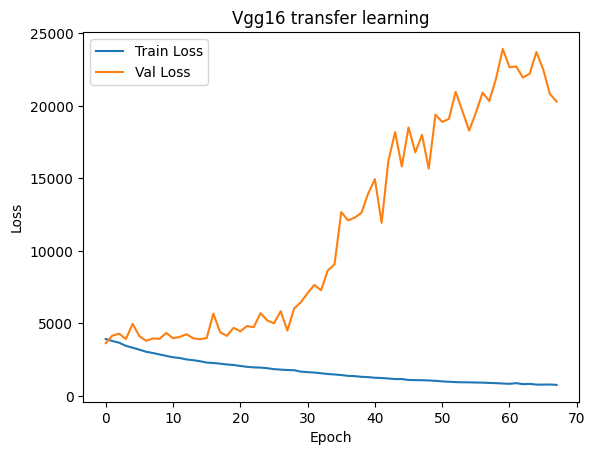

In [10]:
loss=model_vgg.history.history['loss'] #MAE
val_loss=model_vgg.history.history['val_loss']

plt.plot(loss, label='Train Loss')
plt.plot(val_loss, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Vgg16 transfer learning')
plt.show()

#The model is overfitting

In [44]:
model=model_vgg

train_loss = []
val_loss = []
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 140, mode = 'auto'),
    tf.keras.callbacks.ModelCheckpoint(monitor='val_loss',mode='min',save_best_only=True,filepath=os.path.join("models",'model.{epoch:02d}-{val_loss:.2f}.h5'))
]

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='mean_squared_error', metrics=['mean_squared_error'], run_eagerly=True)

# Training loop
num_epochs=700

#model=tf.keras.models.load_model("models\\model.03-3695.77.h5")
for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch+1, num_epochs))
    
    # Fit the model and record the loss values
    history = model.fit(train_ds, validation_data=val_ds, epochs=num_epochs,callbacks=my_callbacks,verbose=1)
    train_loss.append(history.history['loss'])
    val_loss.append(history.history['val_loss'])
    
    # Print the loss for the current epoch
    print('Train Loss: {:.4f}'.format(train_loss[-1]))
    print('Val Loss: {:.4f}'.format(val_loss[-1]))

    np.save('my_history.npy',model.history)
    
    # Plot the loss evolution
    plt.plot(np.arange(epoch+1), train_loss, label='Train Loss')
    plt.plot(np.arange(epoch+1), val_loss, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

#with open('training_history.pkl', 'wb') as file:
#    pickle.dump(model.history, file)
model.save(os.path.join('models','last_epoch_model.h5'))

np.save('my_history.npy',model.history)

#THE MODEL IS LCEARLY OVER-FITTING

Epoch 1/700
Epoch 1/700
1649/1649 [==============================] - 653s 396ms/step - loss: 3709.0986 - mean_squared_error: 3709.0986 - val_loss: 125605.0781 - val_mean_squared_error: 125605.0781
Epoch 2/700
1649/1649 [==============================] - 652s 394ms/step - loss: 3203.6172 - mean_squared_error: 3203.6172 - val_loss: 285141.4062 - val_mean_squared_error: 285141.4062
Epoch 3/700
1649/1649 [==============================] - 642s 389ms/step - loss: 3001.7017 - mean_squared_error: 3001.7017 - val_loss: 453067.5000 - val_mean_squared_error: 453067.5000
Epoch 4/700
1649/1649 [==============================] - 653s 395ms/step - loss: 2761.5176 - mean_squared_error: 2761.5176 - val_loss: 121450.5547 - val_mean_squared_error: 121450.5547
Epoch 5/700
1649/1649 [==============================] - 653s 395ms/step - loss: 2465.9949 - mean_squared_error: 2465.9949 - val_loss: 116499.5000 - val_mean_squared_error: 116499.5000
Epoch 6/700
1649/1649 [==============================] - 651s 3

KeyboardInterrupt: 

In [16]:
'''
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from tensorflow.keras import Input

# Define and compile your model architecture

model=tf.keras.applications.VGG16(include_top=False)

model_input=model.layers[0].input #acces to the input of the first layer
model_output=model.layers[-2].output #acces to the output of the layer model.layers[-2]
final_output=Dense(1,activation="linear")(model_output)

model=tf.keras.Model(inputs=model_input,outputs=final_output)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mean_squared_error'], run_eagerly=True)

model.summary()
'''

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0   

In [12]:
#La difference aussi au niveau des performances de vgg et model1 cnn que j ai utilise et le dernier de github est l ajout des batch normalization
#layers qui sont tres importants

#9alab 3la downsampling rak chaftih f wa7ad l article o son role f rendre l entrainement plus fast et plus rapide
#soit en entrainant moins de donnees ou en resizant vers image sghira bzaf ex 64 64


**Changing the learning rate in our sunset model**

In [48]:
model=tf.keras.models.load_model("models\\model.04-3436.49.h5")
model.optimizer.learning_rate.assign(0.000003)
optimizer = model.optimizer.learning_rate
print(optimizer)

<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=3e-06>


In [15]:
 #i can fit again si c est pas suffisant
#cnn model github entire data used
train_loss = []
val_loss = []

# Training loop
num_epochs=150

#model=tf.keras.models.load_model("models\\model.03-3695.77.h5")
for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch+1, num_epochs))
    
    # Fit the model and record the loss values
    history = model.fit(train_ds, validation_data=val_ds, epochs=num_epochs,callbacks=my_callbacks,verbose=1)
    train_loss.append(history.history['loss'])
    val_loss.append(history.history['val_loss'])
    
    # Print the loss for the current epoch
    print('Train Loss: {:.4f}'.format(train_loss[-1]))
    print('Val Loss: {:.4f}'.format(val_loss[-1]))
    
    # Plot the loss evolution
    plt.plot(np.arange(epoch+1), train_loss, label='Train Loss')
    plt.plot(np.arange(epoch+1), val_loss, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

#with open('training_history.pkl', 'wb') as file:
#    pickle.dump(model.history, file)
model.save(os.path.join('models','last_epoch_model.h5'))

np.save('my_history.npy',model.history)

Epoch 1/150
Epoch 1/150
1649/1649 [==============================] - 1498s 902ms/step - loss: 7588.9727 - mean_squared_error: 7588.9727 - val_loss: 14410.1650 - val_mean_squared_error: 14410.1650
Epoch 2/150
1649/1649 [==============================] - 254s 153ms/step - loss: 5630.2148 - mean_squared_error: 5630.2148 - val_loss: 10453.2100 - val_mean_squared_error: 10453.2100
Epoch 3/150
1649/1649 [==============================] - 261s 157ms/step - loss: 5431.3384 - mean_squared_error: 5431.3384 - val_loss: 5833.9902 - val_mean_squared_error: 5833.9902
Epoch 4/150
1649/1649 [==============================] - 258s 156ms/step - loss: 5283.1948 - mean_squared_error: 5283.1948 - val_loss: 5746.0210 - val_mean_squared_error: 5746.0210
Epoch 5/150
1649/1649 [==============================] - 256s 154ms/step - loss: 5220.4927 - mean_squared_error: 5220.4927 - val_loss: 11648.7393 - val_mean_squared_error: 11648.7393
Epoch 6/150
  44/1649 [..............................] - ETA: 3:55 - loss: 4

KeyboardInterrupt: 

**Creating another edited version of sunset model**

In [51]:
# define the model architecture using tf.keras API
num_filters = 8
kernel_size = [3,3]
pool_size = [2,2]
strides = 2
dense_size = 1024
drop_rate = 0.5


def sunset_model_edit():
    ## input
    ### input image logs with shape (64,64,24)
    x_in = tf.keras.Input(shape=(64,64,3))

    ## 1st convolution block
    x = tf.keras.layers.Conv2D(128,[8,8],padding="same",activation='relu')(x_in)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D(pool_size, strides)(x)

    ## 2nd convolution block
    x = tf.keras.layers.Conv2D(64,[8,8],padding="same",activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D(pool_size, strides)(x)

    x = tf.keras.layers.Conv2D(16,[2,2],padding="same",activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D(pool_size, strides)(x)

    

    ## two fully connected nets
    x = tf.keras.layers.Flatten()(x)

    x = tf.keras.layers.Dense(dense_size, activation='relu')(x)
    x = tf.keras.layers.Dropout(drop_rate)(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.Dropout(drop_rate)(x)

    ## regression to prediction target
    y_out = tf.keras.layers.Dense(units=1,activation='linear')(x)

    # construct the model
    model = tf.keras.Model(inputs=x_in,outputs=y_out)

    return model

# show model architecture
sunset_model_edit().summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 64, 64, 128)       24704     
                                                                 
 batch_normalization_9 (Batc  (None, 64, 64, 128)      512       
 hNormalization)                                                 
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 32, 32, 128)      0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 32, 32, 64)        524352    
                                                                 
 batch_normalization_10 (Bat  (None, 32, 32, 64)       256 

**Compiling andd training the new version**

In [52]:
model_sunset_edit=sunset_model_edit()
model_sunset_edit.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mean_squared_error'], run_eagerly=True)

my_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 40, mode = 'auto'),
    tf.keras.callbacks.ModelCheckpoint(monitor='val_loss',mode='min',save_best_only=True,filepath=os.path.join("models",'model.{epoch:02d}-{val_loss:.2f}.h5'))
]

model_sunset_edit.fit(train_ds, validation_data=val_ds, epochs=150,callbacks=my_callbacks) #i can fit again si c est pas suffisant
#cnn model github entire data used

#with open('training_history.pkl', 'wb') as file:
#    pickle.dump(model.history, file)
model.save(os.path.join('models','last_epoch_model.h5'))

np.save('my_history.npy',model.history)

Epoch 1/150
825/825 [==============================] - 193s 230ms/step - loss: 7881.2041 - mean_squared_error: 7881.2041 - val_loss: 29607.4805 - val_mean_squared_error: 29607.4805
Epoch 2/150
825/825 [==============================] - 192s 232ms/step - loss: 5388.8901 - mean_squared_error: 5388.8901 - val_loss: 15759.0732 - val_mean_squared_error: 15759.0732
Epoch 3/150
825/825 [==============================] - 191s 231ms/step - loss: 5248.5850 - mean_squared_error: 5248.5850 - val_loss: 9581.1338 - val_mean_squared_error: 9581.1338
Epoch 4/150
825/825 [==============================] - 189s 229ms/step - loss: 5070.0952 - mean_squared_error: 5070.0952 - val_loss: 9988.1641 - val_mean_squared_error: 9988.1641
Epoch 5/150
825/825 [==============================] - 191s 231ms/step - loss: 4955.8896 - mean_squared_error: 4955.8896 - val_loss: 14850.7217 - val_mean_squared_error: 14850.7217
Epoch 6/150
825/825 [==============================] - 190s 229ms/step - loss: 4849.4434 - mean_squ

KeyboardInterrupt: 

In [28]:
model.fit(train_ds, validation_data=val_ds, epochs=150,callbacks=my_callbacks) #i can fit again si c est pas suffisant
#cnn model github entire data used

#with open('training_history.pkl', 'wb') as file:
#    pickle.dump(model.history, file)
model.save(os.path.join('models','last_epoch_model.h5'))

np.save('my_history.npy',model.history)


Epoch 1/150
825/825 [==============================] - 1537s 2s/step - loss: 8601.9619 - mean_squared_error: 8601.9619 - val_loss: 4323.4526 - val_mean_squared_error: 4323.4526
Epoch 2/150
825/825 [==============================] - 96s 116ms/step - loss: 5514.7759 - mean_squared_error: 5514.7759 - val_loss: 5256.4746 - val_mean_squared_error: 5256.4746
Epoch 3/150
825/825 [==============================] - 92s 111ms/step - loss: 5162.6533 - mean_squared_error: 5162.6533 - val_loss: 3885.3369 - val_mean_squared_error: 3885.3369
Epoch 4/150
825/825 [==============================] - 92s 111ms/step - loss: 5140.0186 - mean_squared_error: 5140.0186 - val_loss: 3589.1936 - val_mean_squared_error: 3589.1936
Epoch 5/150
825/825 [==============================] - 92s 111ms/step - loss: 4925.8369 - mean_squared_error: 4925.8369 - val_loss: 4513.0938 - val_mean_squared_error: 4513.0938
Epoch 6/150
825/825 [==============================] - 93s 112ms/step - loss: 4862.7061 - mean_squared_error: 4

KeyboardInterrupt: 